In [1]:
import os
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_output_dir = 'tmp_transform_output'
os.makedirs(transform_output_dir, exist_ok=True)

slice_idx = 150
space = [0.7,0.7,1.0]
a_min = -42
a_max = 423
roi_x, roi_y, roi_z = [128, 128, 128]

data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'
data_dict = {
    'image': os.path.join(data_dir, 'pid_1000','pid_1000.nii.gz'),
    'label': os.path.join(data_dir, 'pid_1000','pid_1000_gt.nii.gz')
}

data_dict

{'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz',
 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz'}

## utils

In [3]:
def save_img(data, slice_idx, file_name):
    plt.imshow(data['image'][0, :,:,slice_idx], cmap='gray')
    plt.axis('off')
    plt.savefig(
        os.path.join(transform_output_dir, file_name),
        bbox_inches='tight',
        pad_inches=0
    )

## origin

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


image shape: torch.Size([1, 512, 512, 357])


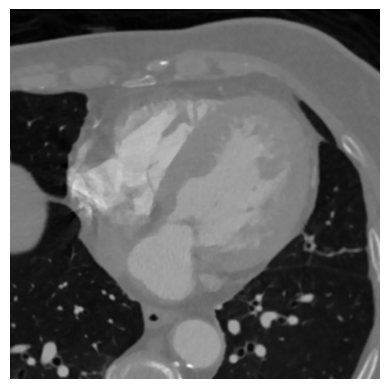

In [4]:
load_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
    ]
)

data = load_transform(data_dict)

print('image shape:', data['image'].shape)

save_img(data, slice_idx, "origin.png")

## spaceing

image shape: torch.Size([1, 270, 270, 143])
270.0 = 512*0.369140625/0.7 
270.0 = 512*0.369140625/0.7 
143 = 357*0.4000000059604645/1.0
transformed slice idx: 60


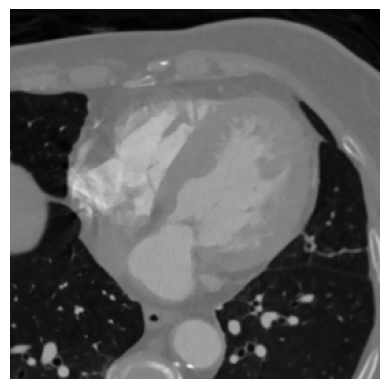

In [5]:
space_transform = Spacingd(
    keys=["image", "label"],
    pixdim=space,
    mode=("bilinear", "nearest"),
)

space_data = space_transform(data)

c, w, h, d = space_data['image'].shape
ori_w, ori_h, ori_d = list(space_data['image_meta_dict']['spatial_shape'])
ori_x, ori_y, ori_z = list(space_data['image_meta_dict']['pixdim'])[1:4]
tgt_x, tgt_y, tgt_z = space
print('image shape:', space_data['image'].shape)
print(f'\
{ori_w*ori_x/tgt_x} = {ori_w}*{ori_x}/{tgt_x} \n\
{ori_h*ori_y/tgt_y} = {ori_h}*{ori_y}/{tgt_y} \n\
{round(ori_d*ori_z/tgt_z)} = {ori_d}*{ori_z}/{tgt_z}'
)

transformed_slice_idx = round(slice_idx*ori_z/tgt_z)
print('transformed slice idx:', transformed_slice_idx)

save_img(space_data, transformed_slice_idx, "space.png")

## intensity

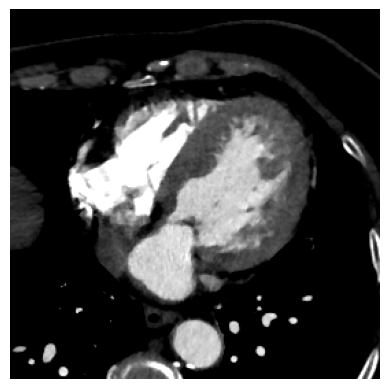

In [6]:
intensity_transform = ScaleIntensityRanged(
    keys=["image"], 
    a_min=a_min, 
    a_max=a_max, 
    b_min=0.0, 
    b_max=1.0, 
    clip=True
)

intensity_data = intensity_transform(space_data)

save_img(intensity_data, transformed_slice_idx, "intensity.png")

## rand crop by pos neg

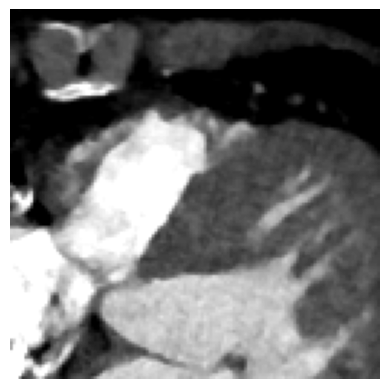

In [7]:
rand_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(roi_x, roi_y, roi_z),
    pos=1,
    neg=1,
    num_samples=1,
    image_key="image",
    image_threshold=0,
)

# set seed for reproducibility
rand_crop_transform.set_random_state(seed=1234)

rand_crop_data = rand_crop_transform(intensity_data)

save_img(rand_crop_data[0], transformed_slice_idx, "rand_crop.png")

## rand flip axis

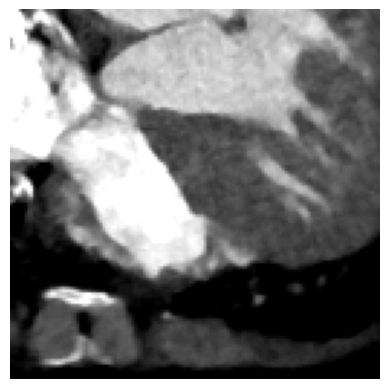

In [8]:
rand_flip_axis_0_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[0],
    prob=1.0,
)

rand_flip_axis_0_data = rand_flip_axis_0_transform(rand_crop_data[0])

save_img(rand_flip_axis_0_data, transformed_slice_idx, "rand_flip_axis_0.png")

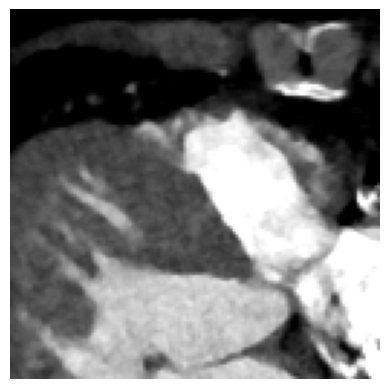

In [9]:
rand_flip_axis_1_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[1],
    prob=1.0,
)

rand_flip_axis_1_data = rand_flip_axis_1_transform(rand_crop_data[0])


save_img(rand_flip_axis_1_data, transformed_slice_idx, "rand_flip_axis_1.png")

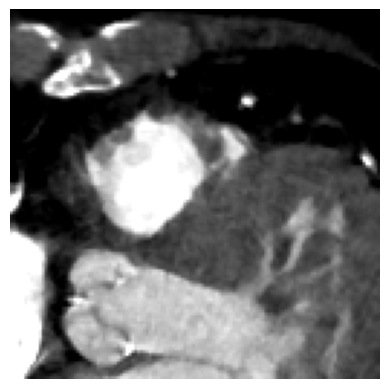

In [10]:
rand_flip_axis_2_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[2],
    prob=1.0,
)

rand_flip_axis_2_data = rand_flip_axis_2_transform(rand_crop_data[0])

save_img(rand_flip_axis_2_data, transformed_slice_idx, "rand_flip_axis_2.png")

## rand rotate 90

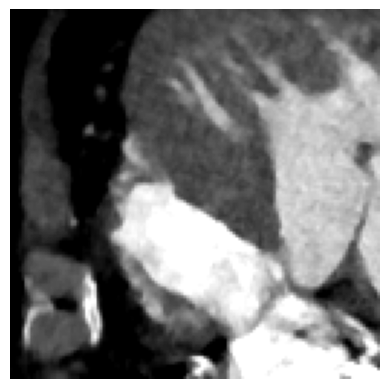

In [11]:
rand_rot_transform_1 = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

# set seed for reproducibility
rand_rot_transform_1.set_random_state(seed=0)

rand_rot_data_1 = rand_rot_transform_1(rand_crop_data[0])


save_img(rand_rot_data_1, transformed_slice_idx, "rand_rot_1.png")

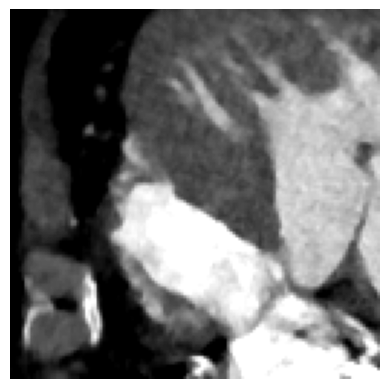

In [12]:
rand_rot_transform_2 = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

# set seed for reproducibility
rand_rot_transform_2.set_random_state(seed=1)

rand_rot_data_2 = rand_rot_transform_1(rand_crop_data[0])


save_img(rand_rot_data_2, transformed_slice_idx, "rand_rot_2.png")

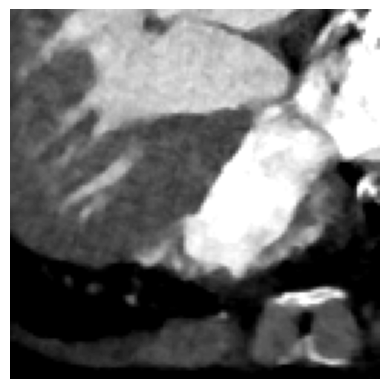

In [13]:
rand_rot_transform_3 = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

# set seed for reproducibility
rand_rot_transform_3.set_random_state(seed=2)

rand_rot_data_3 = rand_rot_transform_1(rand_crop_data[0])


save_img(rand_rot_data_3, transformed_slice_idx, "rand_rot_3.png")

## zip result

In [14]:
!zip -r {transform_output_dir}.zip {transform_output_dir}

  adding: tmp_transform_output/ (stored 0%)
  adding: tmp_transform_output/origin.png (deflated 1%)
  adding: tmp_transform_output/space.png (deflated 1%)
  adding: tmp_transform_output/intensity.png (deflated 2%)
  adding: tmp_transform_output/rand_crop.png (deflated 1%)
  adding: tmp_transform_output/rand_flip_axis_1.png (deflated 1%)
  adding: tmp_transform_output/rand_flip_axis_2.png (deflated 1%)
  adding: tmp_transform_output/rand_rot_1.png (deflated 1%)
  adding: tmp_transform_output/rand_rot_2.png (deflated 1%)
  adding: tmp_transform_output/rand_rot_3.png (deflated 1%)
  adding: tmp_transform_output/rand_flip_axis_0.png (deflated 1%)
